<a href="https://colab.research.google.com/github/lizhieffe/Reinforcement-Learning/blob/master/RL_Model_Based_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

In [2]:
# Used by Epsilon-Greedy
_EPSILON = 0.5

In [3]:
# index 0: the id of the state
# index 1: the id of the action
# value: the id of the next state

state_transition_table = [
    [0, 1, 4, 0],
    [1, 2, 5, 0],
    [2, 3, 6, 1],
    [3, 3, 7, 2],
    [0, 5, 8, 4],
    [1, 6, 9, 4],
    [2, 7, 10, 5],
    [3, 7, 11, 6],
    [4, 9, 12, 8],
    [5, 10, 13, 8],
    [6, 11, 14, 9],
    [7, 11, 15, 10],
    [8, 13, 12, 12],
    [9, 14, 13, 12],
    [10, 15, 14, 13],
    [11, 15, 15, 14]
]

num_states = len(state_transition_table)

In [5]:
terminal_state = 3

rewards = np.zeros(num_states)
rewards[terminal_state] = 10

rewards[2] = -1
rewards[11] = -1
rewards[10] = -1

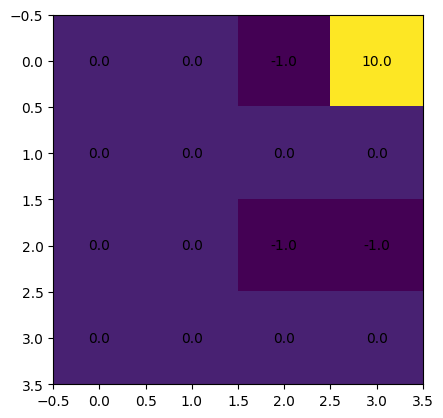

In [6]:
fig1, ax1 = plt.subplots(1)

ax1.imshow(rewards.reshape(4,4))

for (j, i), label in np.ndenumerate(rewards.reshape(4,4).round(4)):
  ax1.text(i, j, label, ha='center', va='center')

In [8]:
gamma = 0.9

In [9]:
# @title An agent to test the value table.

def test_agent():
  """Use greedy action selection to run a trajectory based on the current state_values.

  Returns:
    [0]: the total reward on the trajectory.
    [1]: the states on the trajectory.
  """
  state = 12
  done = False
  steps = 0
  total_rewards = 0
  states_log = []

  while (not(state == terminal_state)) and steps < 40:
    states_log.append(state)
    # print(f"{state=}, {state_transition_table[state]=}")
    # print(f"{state=}, {state_transition_table[state]=}, {state_values[state_transition_table[state]]=}")
    # break
    action = np.argmax(state_values[state_transition_table[state]])
    state = state_transition_table[state][action]
    total_rewards += rewards[state]
    steps += 1

  states_log.append(state)
  return total_rewards, states_log

In [10]:
class VanillaStateValuesUpdater():
  def __init__(self):
    # log of the returns on each trajectory. Each element is a single trajectory.
    self.returns_log = []

  def _returns(self, values: list[int], rewards: list[int], states: list[int]) -> list[float]:
    """Intake one trajectory and calculate the returns.

    Args:
      values: the current values of each state. Not used.
      rewards: the rewards along the trajectory.
      states: the states along the trajectory.

    Returns:
      The returns along the trajectory.
    """
    del values

    state_visit_counts = np.zeros(num_states)
    state_returns = np.zeros(num_states)

    ret = 0

    for i in reversed(range(len(states))):
      state = states[i]
      reward = rewards[i]

      ret = reward + gamma * ret
      state_returns[state] += ret
      state_visit_counts[state] += 1

    state_returns = state_returns / (state_visit_counts + 1e-4)

    return state_returns

  def update(self, values: list[int], rewards: list[int], states: list[int]) -> list[float]:
    """Update the state values.

    Args:
      values: the current values of each state. Not used.
      rewards: the rewards along the new trajectory.
      states: the states along the new trajectory.

    Returns:
      The updated state values.
    """
    ret = self._returns(values, rewards, states)
    self.returns_log.append(ret)
    return np.mean(self.returns_log, 0)

class MonteCarloStateValuesUpdater():
  """Compared to vanilla, MC has difference
  1) it updates immediately on each step of a trajectory, instead of waiting for a trajectory finishes then update
  2) it updates smoothly with alpha; this is helpful because the rewards are sparse.
  """

  alpha = 0.05

  def update(self, values: list[int], rewards: list[int], states: list[int]) -> list[float]:
    """Update the state values.

    Args:
      values: the current values of each state. Not used.
      rewards: the rewards along the new trajectory.
      states: the states along the new trajectory.

    Returns:
      The updated state values.
    """
    assert len(rewards) == len(states)
    ret = 0
    updated_values = copy.deepcopy(values)

    for i in reversed(range(len(states))):
      state = states[i]
      reward = rewards[i]
      ret = reward + gamma * ret
      updated_values[state] = updated_values[state] + self.alpha * (ret - updated_values[state])

    return updated_values


class TemperalDifferenceStateValuesUpdater():
  """Compared to MC, the differences are
  1) it updates using td-error, instead of the return of the current trajectory, to make the update smoothly for the sparse rewards in the trajectory.
  """

  alpha = 0.05

  def update(self, values: list[int], rewards: list[int], states: list[int]) -> list[float]:
    """Update the state values.

    Args:
      values: the current values of each state. Not used.
      rewards: the rewards along the new trajectory.
      states: the states along the new trajectory.

    Returns:
      The updated state values.
    """
    assert len(rewards) == len(states)
    updated_values = copy.deepcopy(values)

    next_state_value = 0

    for i in reversed(range(len(states))):

      state = states[i]
      reward = rewards[i]

      curr_state_value = state_values[state]

      td_err = reward + gamma * next_state_value - curr_state_value


      updated_values[state] = updated_values[state] + self.alpha * td_err
      next_state_value = curr_state_value

    return updated_values

state_values_updater = VanillaStateValuesUpdater()
state_values_updater = MonteCarloStateValuesUpdater()
state_values_updater = TemperalDifferenceStateValuesUpdater()

state_values = np.zeros(num_states)
score_log = []

for i in range(1000):
  state = 12
  state_log = []
  reward_log = []
  steps = 0

  while (not(state == terminal_state)) and steps < 40:
    reward_log.append(rewards[state])
    state_log.append(state)

    if random.uniform(0, 1) > _EPSILON:
      # Exploitation
      action = np.argmax(state_values[state_transition_table[state]])
    else:
      # Exploration
      action = random.randint(0, 3)
    state = state_transition_table[state][action]
    steps += 1

  reward_log.append(rewards[state])
  state_log.append(state)

  # if i == 998:
  #   print(f"{state_values=}")
  #   print(f"{reward_log=}")
  #   print(f"{state_log=}")
  # ret = returns(state_values, reward_log, state_log)

  state_values = state_values_updater.update(state_values, reward_log, state_log)

  score_log.append(test_agent()[0])

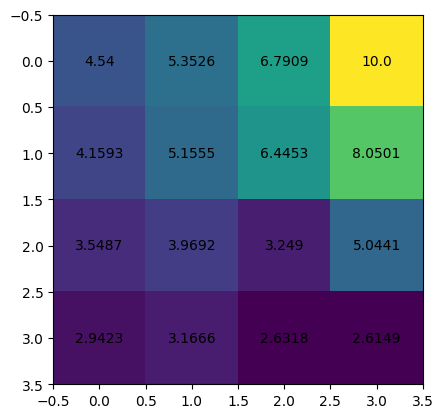

In [12]:
# Plot the state values grid

fig1, ax1 = plt.subplots(1)
ax1.imshow(state_values.reshape(4,4))

for (j, i), label in np.ndenumerate(state_values.reshape(4,4).round(4)):
  ax1.text(i, j, label, ha='center', va='center')

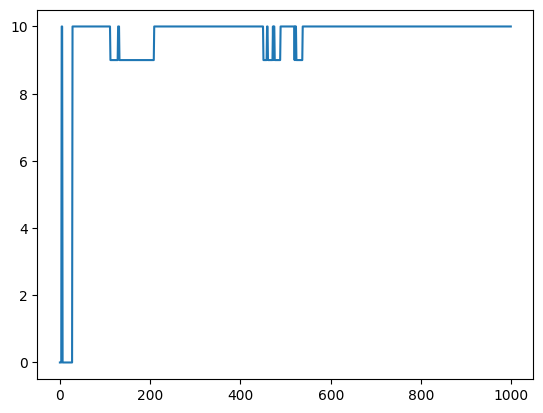

In [13]:
plt.plot(score_log)

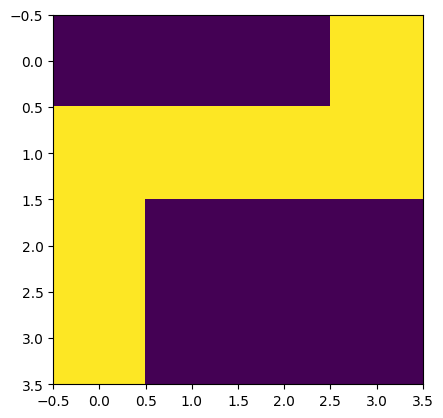

In [14]:
_, state_log = test_agent()
state_view = np.zeros(num_states)
state_view[state_log] = 1
plt.imshow(state_view.reshape(4,4))

In [15]:
state_log

[12, 8, 4, 5, 6, 7, 3]